In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/My Drive/P1_Facial_Keypoints

/content/drive/My Drive/P1_Facial_Keypoints


In [ ]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import random
# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.optim import lr_scheduler


**Transform the dataset**

The necessary transforms have been defined in data_load.py as seen in prev notebook. So we will just use that.

**Splitting the dataset into train and valid dataset and whole pipeline for loading dataset**

---



In [ ]:

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset

# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomRotate, RandomHorizontalFlip, RandomCrop, Normalize,ToTensor,Random90DegFlip,FaceCropTight,FaceCrop

def create_datasets(batch_size, img_size, color=False):

    # percentage of test set to use as validation
    valid_size = 0.5
    
    # create transforms
    train_transform = transforms.Compose([RandomRotate(5),
                                          RandomHorizontalFlip(),
                                          Random90DegFlip(),
                                          FaceCrop(),
                                          Rescale((img_size,img_size)),
                                          Normalize(color=color),
                                          ToTensor()])
    
    # create transforms
    valid_transform = transforms.Compose([FaceCropTight(),
                                          Rescale((img_size,img_size)),
                                          Normalize(color=color),
                                          ToTensor()])
    # create transforms
    test_transform = transforms.Compose([FaceCropTight(),
                                          Rescale((img_size,img_size)),
                                          Normalize(color=color),
                                          ToTensor()])
                
    # create the test dataset
    test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                          root_dir='data/test/',
                                          transform=test_transform)

    # create new training dataset for each epoch
    train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                           root_dir='data/training/',
                                           transform=train_transform)
    
    # create new valid dataset for each epoch
    valid_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                           root_dir='data/test/',
                                           transform=valid_transform)
            
    # obtain test indices that will be used for validation
    num_test = len(test_dataset)
    indices = list(range(num_test))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_test))
    test_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    test_sampler = SubsetRandomSampler(test_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True, 
                              num_workers=0)
    
    # load validation data in batches
    valid_loader = DataLoader(valid_dataset,
                              batch_size=batch_size, 
                              sampler=valid_sampler,
                              num_workers=0)
    
    # load test data in batches
    test_loader = DataLoader(test_dataset, 
                             batch_size=batch_size,
                             sampler=test_sampler, 
                             num_workers=0)
    
    return train_loader, test_loader, valid_loader

**Validation loss function for validation**

In [ ]:
# Test the net ona all test images and return average loss
def validation_loss(valid_loader, net):

    # set the module to evaluation mode
    net.eval()
    loss = 0.0
    running_loss = 0.0

    # iterate through the valid dataset
    for i, batch in enumerate(valid_loader):
        # get sample data: images and ground truth keypoints
        images = batch['image']
        key_pts = batch['keypoints']
        
        # flatten pts
        key_pts = key_pts.view(key_pts.size(0), -1)
                
        # convert variables to floats for regression loss
        key_pts = key_pts.type(torch.FloatTensor).to(device)
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        
        # calculate the loss between predicted and target keypoints
        loss = criterion(output_pts, key_pts)
        running_loss += loss.item()
    avg_loss = running_loss/(i+1)
    net.train()
    return avg_loss

**Early Stopping class**

This is regularization technique to avoid overfitiing on the train set.This will keep track of validation loss and will check if it is decreasing or not.if the loss stops decreasing several epochs in a row then training stops.
Also we are using **save_checkpoints** so that it  could save a checkpoint (a copy of the best model) when the validation loss is at its lowest, then we can revert to the checkpoint after early stopping.

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss dosen't improve after a given patience."""
    def __init__(self,patience=15):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved. 
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
    
    def __call__(self, val_loss, model):
        
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'saved_models/checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
import csv

def write_list_to_file(list_values, filename):
    """Write the list to csv file."""
    with open(filename, "w") as outfile:
        for entries in list_values:
            outfile.write(str(entries))
            outfile.write("\n")

**Transfer Learnig**

In [ ]:
def train_transfer(model, scheduler, n_epochs = 100, name = "",patience=15):
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            targets = data['keypoints']
            
            # flatten pts
            targets = targets.view(targets.size(0), -1)
    
            # convert variables to floats for regression loss
            targets = targets.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            # calculate the batch loss
            loss = criterion(output, targets)
            # backward pass: compute gradient of the loss with respect to the model
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss +=  ((1 / (batch_i + 1)) * (loss.data - train_loss))
        
        val_loss = validation_loss(valid_loader, model)
        
        scheduler.step(val_loss)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch, 
            train_loss,
            val_loss
            ))
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load last checkpoint with the best model
    model.load_state_dict(torch.load('saved_models/checkpoint.pt'))
    val_loss  = validation_loss(valid_loader, model)
    torch.save(model.state_dict(), f'saved_models/{name}_epochs{epoch}_bs{batch_size}_vloss{val_loss:.5f}.pt')
    print('Finished Training')

**pre trained resnet**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
from models import resnet18_grayscale
batch_size = 64
image_size = 224
# prepare data loaders
train_loader, test_loader, valid_loader = create_datasets(batch_size,image_size,color=False)
resnet18_net = resnet18_grayscale()

for param in resnet18_net.parameters():
    param.requires_grad_(True)

resnet18_net=resnet18_net.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(resnet18_net.parameters(), lr=0.001)
# reduce learning rate when a validation loss has stopped improving
plateau_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',  patience=7, verbose=True)
train_transfer(resnet18_net, plateau_lr_scheduler,100, "resnet18_gray", 15)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch: 1 	Training Loss: 0.13984 	Validation Loss: 0.11270
Epoch: 2 	Training Loss: 0.04397 	Validation Loss: 0.02519
Validation loss decreased (inf --> 0.025188).  Saving model ...
Epoch: 3 	Training Loss: 0.03875 	Validation Loss: 0.02421
Validation loss decreased (0.025188 --> 0.024211).  Saving model ...
Epoch: 4 	Training Loss: 0.02242 	Validation Loss: 0.02065
Validation loss decreased (0.024211 --> 0.020651).  Saving model ...
Epoch: 5 	Training Loss: 0.02163 	Validation Loss: 0.01763
Validation loss decreased (0.020651 --> 0.017628).  Saving model ...
Epoch: 6 	Training Loss: 0.01932 	Validation Loss: 0.01605
Validation loss decreased (0.017628 --> 0.016050).  Saving model ...
Epoch: 7 	Training Loss: 0.02146 	Validation Loss: 0.01483
Validation loss decreased (0.016050 --> 0.014829).  Saving model ...
Epoch: 8 	Training Loss: 0.01869 	Validation Loss: 0.01962
EarlyStopping counter: 1 out of 15
Epoch: 9 	Training Loss: 0.01715 	Validation Loss: 0.01617
EarlyStopping counter: 2

**functio for Getting output from the model of input image**

In [ ]:
def net_sample_output(test_net, data_loader):
    test_net.eval()
    # iterate through the test dataset
    for i, sample in enumerate(data_loader):
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
                
        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = test_net(images)
                
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

**Saving the model for further use. Also get output for testset**

In [ ]:
from models import resnet18_grayscale
# prepare data loaders
img_size = 224
bs = 15

_, test_loader, _ = create_datasets(bs, 224, color=False)

model = resnet18_grayscale()

#/content/drive/My Drive/P1_Facial_Keypoints/saved_models/resnet18_gray_epochs1_bs64_vloss0.01931.pt
model_dir = 'saved_models/'
model_name = 'resnet18_gray_epochs46_bs64_vloss0.00524.pt'
model.load_state_dict(torch.load(model_dir + model_name))

model.eval()

test_images, test_outputs, gt_pts = net_sample_output(model, test_loader)
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([15, 1, 224, 224])
torch.Size([15, 68, 2])
torch.Size([15, 68, 2])


**function for visualizing the images and outputs(keypoints)**

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

But this time we have to untransform the data.This function's main role is to take batches of image and keypoint data (the input and output of CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display.
 The un-transformation process turns keypoints and images into numpy arrays from Tensors and it undoes the keypoint normalization done in the Normalize() transform.
 

In [ ]:
def visualize_output(images, outputs, gt_pts=None, batch_size=10):
    plt.figure(figsize=(15,10))
    for i in range(15):    
        ax = plt.subplot(3, 5, i+1)

        # un-transform the image data
        image = images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image,

        # un-transform the predicted key_pts data
        predicted_key_pts = outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*(image.shape[0]/4)+image.shape[0]/2
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*(image.shape[0]/4)+image.shape[0]/2
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

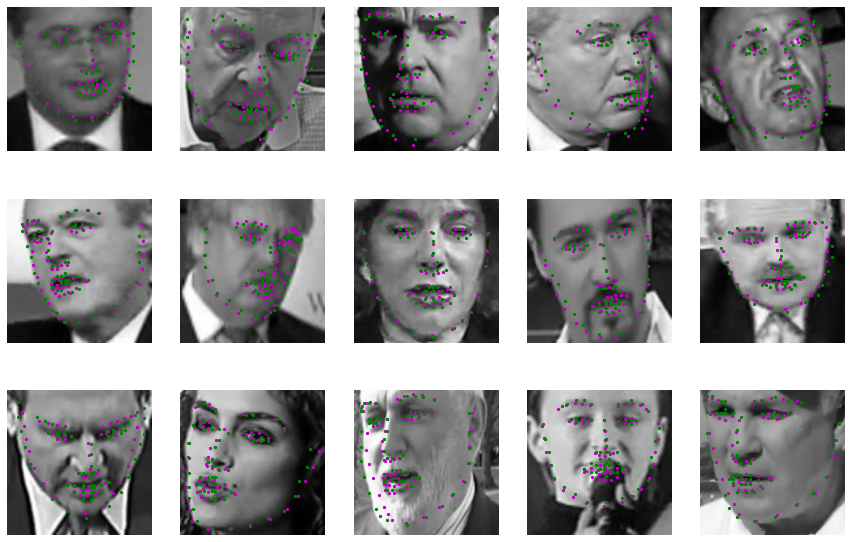

In [ ]:
# visualize your test output
visualize_output(test_images, test_outputs, gt_pts)

That's pretty good result. As we see green and red dots are alligning,meaning predicted and actual points are very close. almose accurate.